# MedMNIST数据可视化以及实验结果分析

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import seaborn as sns
import medmnist
from medmnist import INFO, Evaluator

plt.rcParams['font.family'] = 'serif'

## 初始化数据集列表和模型列表

In [ ]:
data_list = ['retinamnist', 'dermamnist', 'bloodmnist']
# model_list = ['resnet', 'vit', 'vgg', 'next_vit']
model_list = ['resnet', 'vit', 'convnext', 'vgg', 'swin_transformer', 'next_vit']

## 使用MedMNIST库读取数据集文件

In [ ]:
info = INFO[data_list[2]]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

info, DataClass

({'python_class': 'BloodMNIST',
  'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
  'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1',
  'MD5': '7053d0359d879ad8a5505303e11de1dc',
  'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1',
  'MD5_64': '2b94928a2ae4916078ca51e05b6b800b',
  'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1',
  'MD5_128': 'adace1e0ed228fccda1f39692059dd4c',
  'url_224': 'https://zenodo.org/records/10519652/files/b

## 数据集图片的可视化

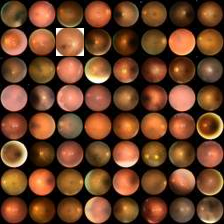

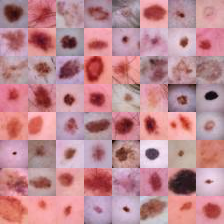

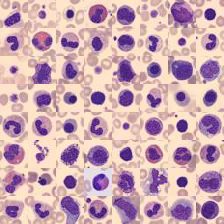

Images have been saved at ./pictures


In [ ]:
for dataset in data_list:
    info = INFO[dataset]
    DataClass = getattr(medmnist, info['python_class'])    

    # load the data
    pil_dataset = DataClass(split='train')

    img = pil_dataset.montage(8)
    display(img)
    img.save(f'./pictures/{dataset}_data_vis.png')
    
print("Images have been saved at ./pictures")

## 计算数据集的标签分布

In [ ]:
acr_dict = {
    'retinamnist':{'2':'2', '1':'1', '0':'0', '3':'3', '4':'4'}, 
    'dermamnist':{'melanocytic nevi': 'MN',
                  'dermatofibroma': 'DER',
                  'melanoma': 'MEL',
                  'actinic keratoses and intraepithelial carcinoma': 'AKIC',
                  'benign keratosis-like lesions': 'BKL',
                  'basal cell carcinoma': 'BCC',
                  'vascular lesions': 'VL'
                }, 
    'bloodmnist':{'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)': 'IG',
                    'basophil': 'BAS',
                    'eosinophil': 'EOS',
                    'neutrophil': 'NEU',
                    'monocyte': 'MON',
                    'erythroblast': 'ERY',
                    'lymphocyte': 'LYM',
                    'platelet': 'PLA'
                }
}

def count_classes(dataset:str):
    info = INFO[dataset]
    DataClass = getattr(medmnist, info['python_class'])  
    pil_dataset = DataClass(split='test')
    class_counts = {}
    label_dict = info['label']
    for _, target in pil_dataset:
        label = acr_dict[dataset][label_dict[str(target.item())]]
        if label in class_counts.keys():
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

count_classes(data_list[2])

{'IG': 579,
 'BAS': 244,
 'EOS': 624,
 'NEU': 666,
 'MON': 284,
 'ERY': 311,
 'LYM': 243,
 'PLA': 470}

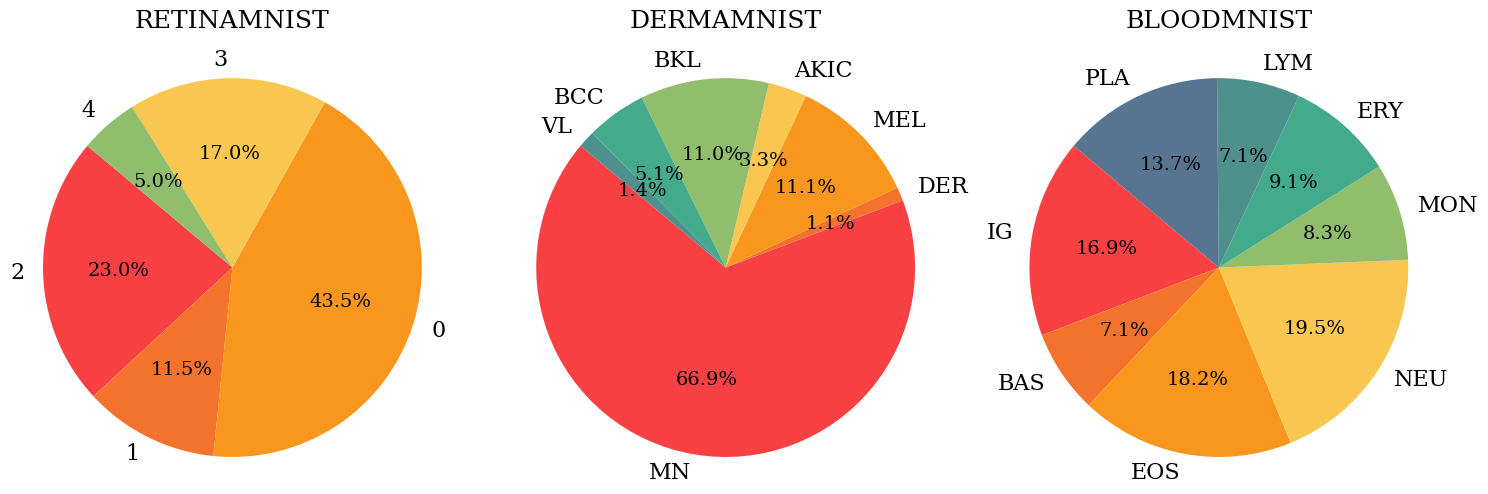

In [ ]:
# 定义颜色列表
colors = ['#f94144', '#f3722c', '#f8961e', '#f9c74f', '#90be6d', '#43aa8b', '#4d908e', '#577590', '#277da1', '#b56576']

fig, axes = plt.subplots(1, len(data_list), figsize=(15, 5))

for i, dataset in enumerate(data_list):
    class_dict = count_classes(dataset=dataset)
    
    wedges, texts, autotexts = axes[i].pie(class_dict.values(), labels=class_dict.keys(), colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
    
    # 设置标签字体大小
    for text in texts:
        text.set_fontsize(16)
    
    # 设置百分比字体大小
    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('black')
    
    axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axes[i].set_title(dataset.upper(), fontsize=18, pad=20)

plt.tight_layout()
plt.savefig(f'./pictures/distribution.png')
plt.show()

## 计算模型参数量

In [ ]:
import timm

def load_model(model_name, num_classes, pretrain=False):
    """
    根据模型名称加载预训练模型，并输出模型信息

    参数:
    model_name (str): 模型名称, 支持'resnet', 'vit', 'convnext', 'vgg', 'swin_transformer', 'next_vit'
    num_classes (int): 类别数量
    pretrain (bool): 是否加载预训练模型，默认为False

    返回:
    model: 返回加载的模型
    """
    print(f"Loading {model_name}....")
    if model_name == 'resnet':
        model = timm.create_model(
            'resnet50', pretrained=pretrain, num_classes=num_classes)
    elif model_name == 'vit':
        model = timm.create_model(
            'vit_small_patch16_224', pretrained=pretrain, num_classes=num_classes)
    elif model_name == 'convnext':
        model = timm.create_model(
            'convnext_tiny', pretrained=pretrain, num_classes=num_classes)
    elif model_name == 'vgg':
        model = timm.create_model(
            'vgg16', pretrained=pretrain, num_classes=num_classes)
    elif model_name == 'swin_transformer':
        model = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrain, num_classes=num_classes)
    elif model_name == 'next_vit':
        model = timm.create_model(
            'nextvit_small', pretrained=pretrain, num_classes=num_classes)
    else:
        raise ValueError("Invalid model name")

    # 计算模型参数量
    num_params = sum(p.numel() for p in model.parameters())

    return {
        'model_name': model_name,
        'num_params': num_params
    }

num_classes = 10
pretrain = True

models_params = {}
for model_name in model_list:
    params = load_model(model_name, num_classes, pretrain)
    models_params[model_name] = params

# 打印模型参数量信息
models_params

Loading resnet....
Loading vit....
Loading convnext....
Loading vgg....
Loading swin_transformer....
Loading next_vit....


{'resnet': {'model_name': 'resnet', 'num_params': 23528522},
 'vit': {'model_name': 'vit', 'num_params': 21669514},
 'convnext': {'model_name': 'convnext', 'num_params': 27827818},
 'vgg': {'model_name': 'vgg', 'num_params': 134301514},
 'swin_transformer': {'model_name': 'swin_transformer',
  'num_params': 27527044},
 'next_vit': {'model_name': 'next_vit', 'num_params': 30748618}}

## 绘制不同模型的Loss曲线对比

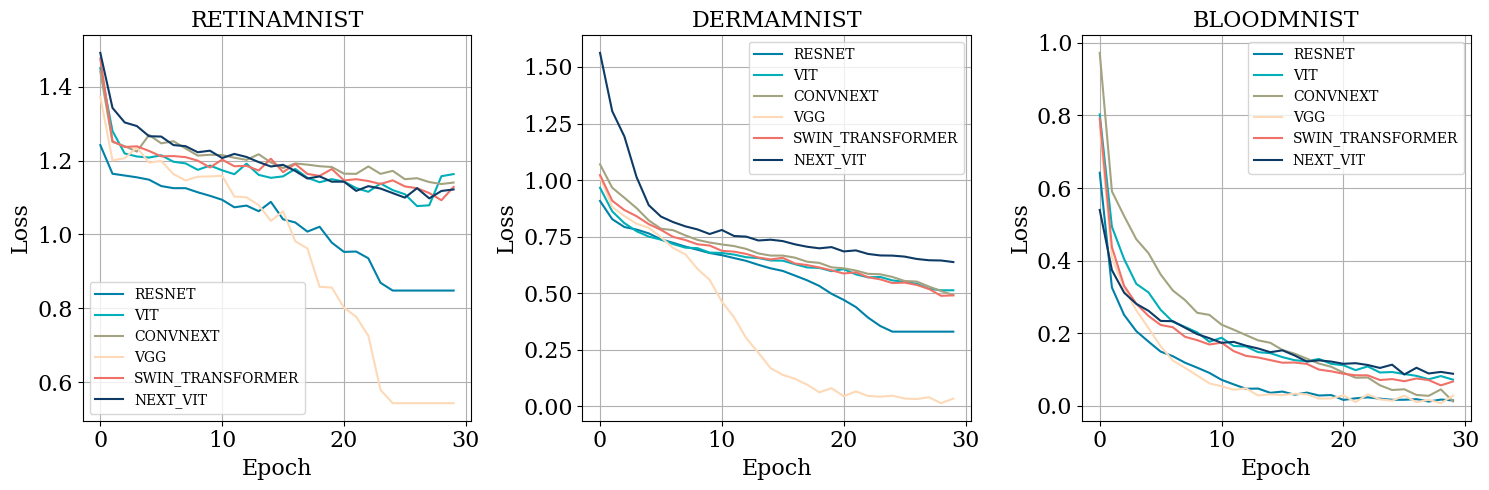

In [ ]:
# 创建一个大图来拼接所有的Loss曲线
fig, axes = plt.subplots(1, len(data_list), figsize=(15, 5))

# 定义颜色和标记
colors = ['#0081a7', '#00afb9', '#a3a380', '#fed9b7', '#f07167', '#0d3b66']
markers = ['o', '^', '*', 's', 'D', 'v']

for i, dataset in enumerate(data_list):
    for j, model in enumerate(model_list):
        # 加载Loss曲线数据
        l_curve = np.load(f'./results/{dataset}/{model}_loss_curve.npy')
        
        # 绘制Loss曲线
        axes[i].plot(l_curve, label=model.upper(), color=colors[j])
    
    # 设置图像标题和标签
    axes[i].set_title(f'{dataset.upper()}', fontsize=16)
    axes[i].set_xlabel('Epoch', fontsize=16)
    axes[i].set_ylabel('Loss', fontsize=16)
    axes[i].legend()
    axes[i].grid(True)

    axes[i].tick_params(axis='both', which='major', labelsize=16)  # 调整刻度字号为12

# 调整布局，避免重叠
plt.tight_layout()

# 保存和显示大图
plt.savefig('./pictures/loss_curves_comparison.png', dpi=200)
plt.show()

## 超参数分析可视化
- 单一参数敏感性分析
- 参数组合敏感性分析

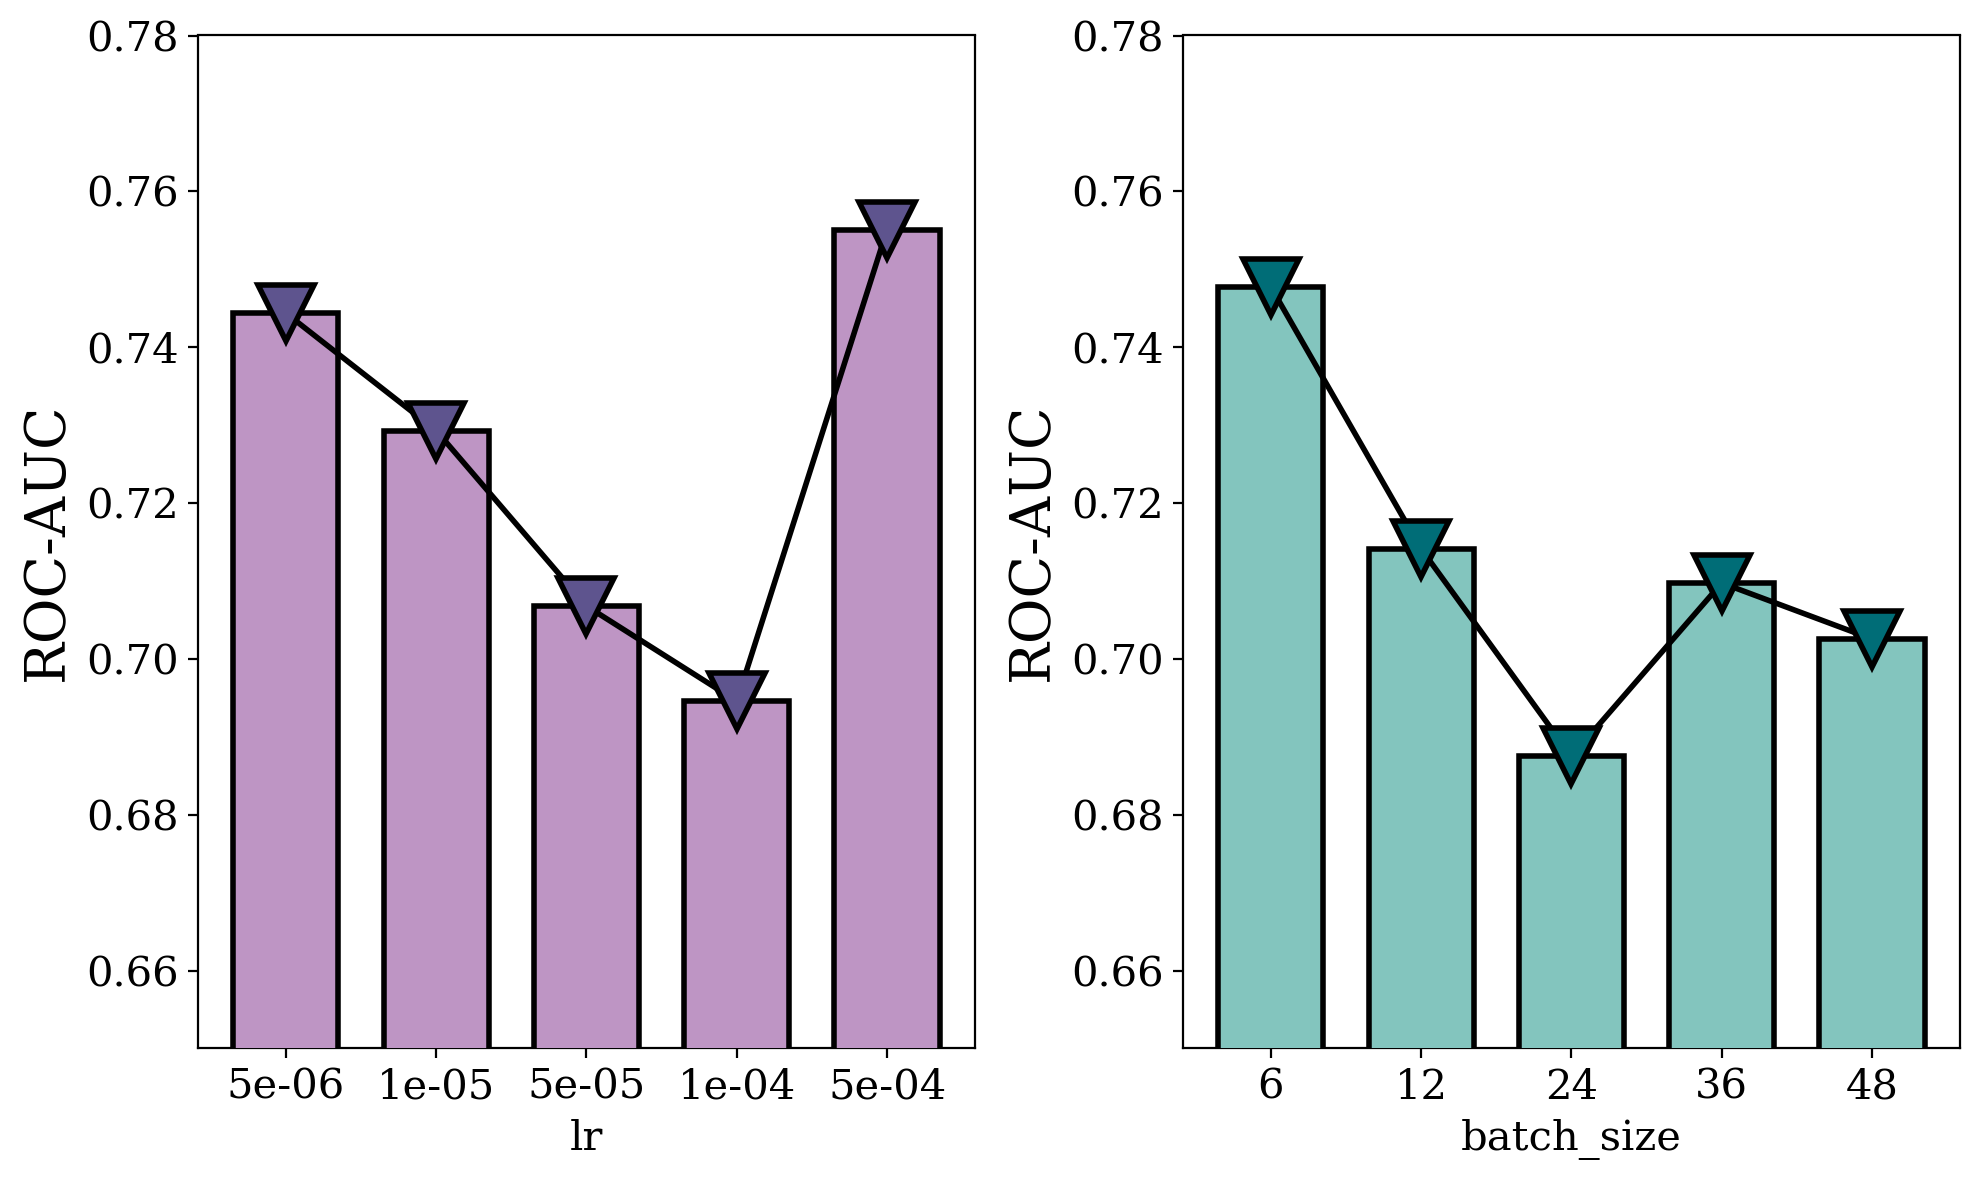

In [ ]:
import json

plt.rcParams['font.family'] = 'serif'

color_dict = {"lr":{"barcolor":'#be95c4',"facecolor":'#5e548e'},"batch_size":{"barcolor":'#83c5be',"facecolor":'#006d77'}}

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=200)
for i, hp in enumerate(["lr", "batch_size"]):
    with open(f"./results/param_analysis/{hp}_res.json", "r", encoding='utf-8') as f:
        data = json.load(f)

    param_values = list(range(1,len(data.keys())+1))

    xparam = []
    roc_auc = []
    for param, metric_dict in data.items():
        if hp == 'lr':
            xparam.append("{:.0e}".format(eval(param)))
        else:
            xparam.append(eval(param))
        roc_auc.append(metric_dict['roc_auc'])

    ax[i].set_ylim(0.65, 0.78)

    ax[i].bar(param_values, roc_auc, color=color_dict[hp]['barcolor'], edgecolor="black", alpha=1, zorder=3, width=0.7, linewidth=2)
    ax[i].set_xticks(param_values)
    ax[i].set_xticklabels(xparam, fontsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    ax[i].set_xlabel(hp, fontsize=15)
    ax[i].set_ylabel('ROC-AUC', fontsize=20)

    ax[i].plot(param_values, roc_auc, color='black', marker='v', markersize=20, zorder=4, markeredgecolor='black', markerfacecolor=color_dict[hp]['facecolor'], linewidth=2, markeredgewidth=2)

    # ax[i].set_title(dataset.upper(), fontsize=20)

plt.tight_layout()
plt.savefig('./pictures/sing_param.png')
plt.show()


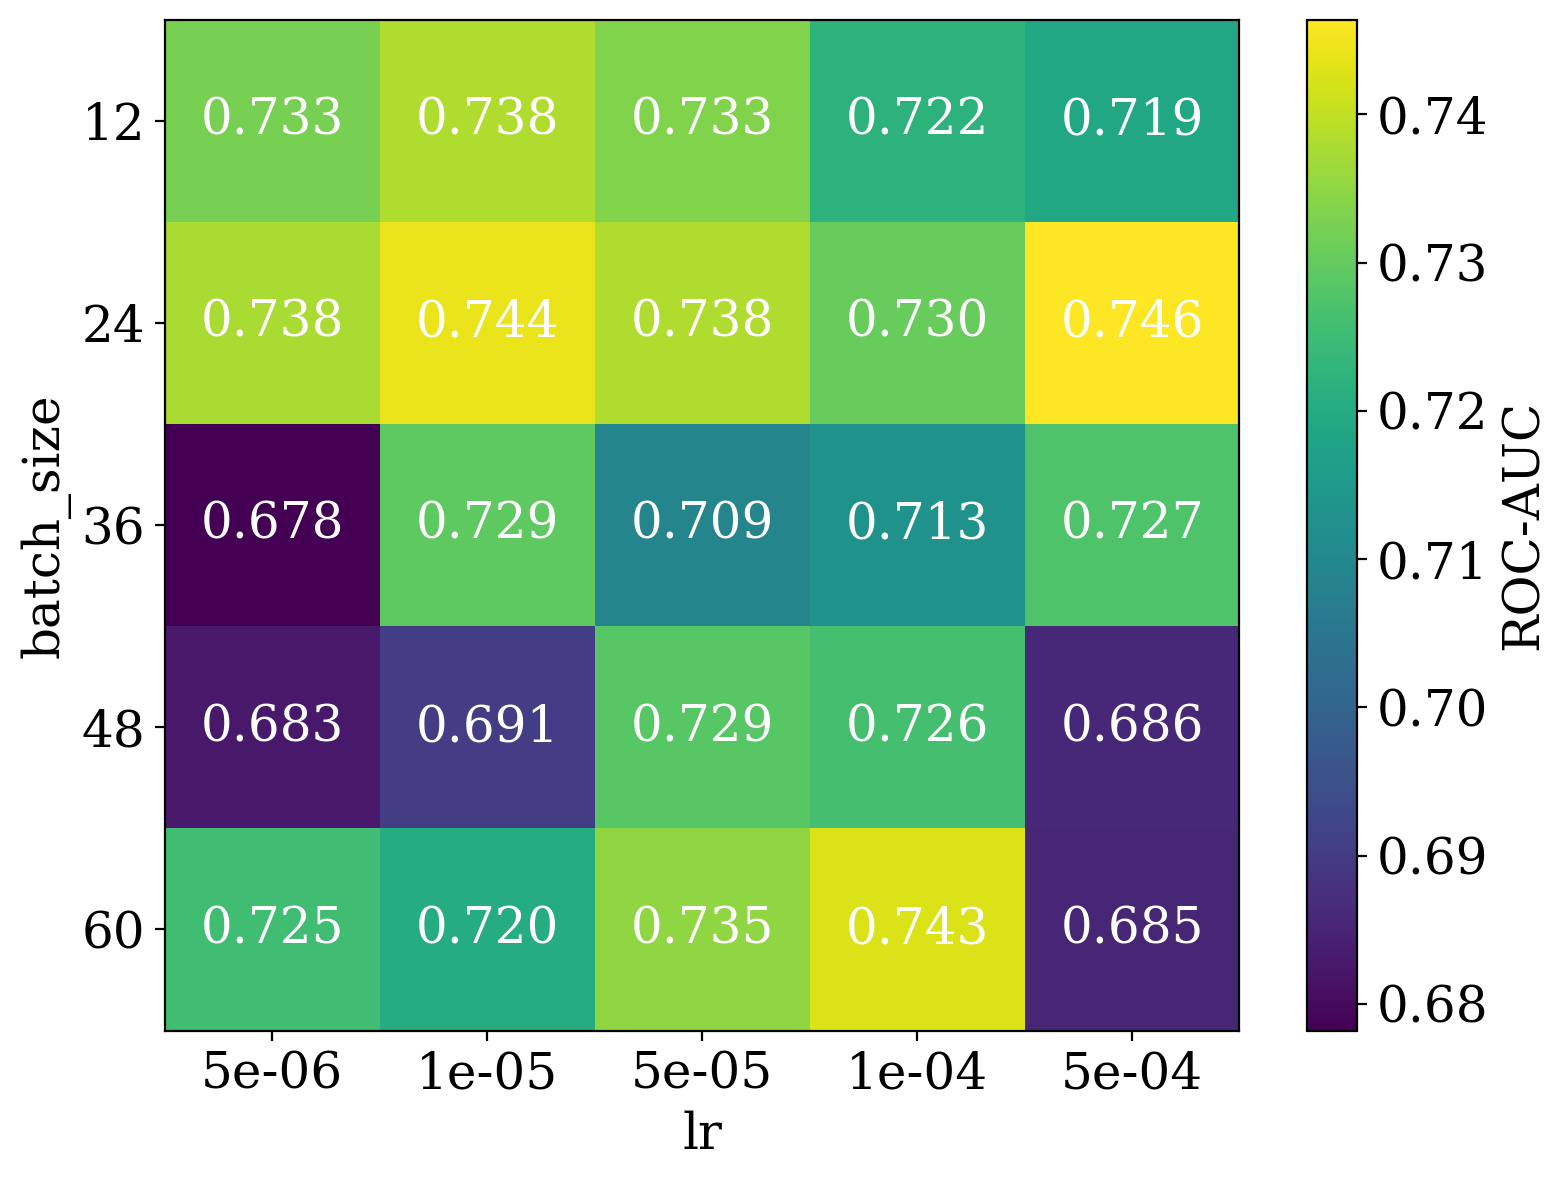

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 读取 JSON 数据
with open("./results/param_analysis/both_res.json", "r", encoding='utf-8') as f:
    data = json.load(f)

# 初始化 X, Y, Z 坐标
x_ticks = []
y_ticks = []
z = np.zeros((5, 5))

# 填充 Z 数据
for i, (k, metric_dict) in enumerate(data.items()):
    lr, batch_size = eval(k)
    if lr not in x_ticks:
        x_ticks.append(lr)
    if batch_size not in y_ticks:
        y_ticks.append(batch_size)
    z[i // 5][i % 5] = metric_dict["roc_auc"]

# 将学习率和批量大小进行排序
x_ticks_sorted = sorted(x_ticks)
y_ticks_sorted = sorted(y_ticks)

# 转换为字符串格式
x_tick_labels = ["{:.0e}".format(label) for label in x_ticks_sorted]
y_tick_labels = [str(label) for label in y_ticks_sorted]

# 创建热力图
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

# 设置标签
ax.set_xlabel('lr', fontsize=18)
ax.set_ylabel('batch_size', fontsize=18)
# ax.set_title('Parameter Analysis of Learning Rate and Batch Size', fontsize=20)

# 设置自定义的刻度
ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_tick_labels, fontsize=18)
ax.set_yticks(np.arange(len(y_ticks)))
ax.set_yticklabels(y_tick_labels, fontsize=18)

# 在热力图上显示数值
for i in range(len(x_ticks)):
    for j in range(len(y_ticks)):
        ax.text(j, i, f"{z[i, j]:.3f}", ha='center', va='center', color='white',fontsize=18)

cax = ax.imshow(z, interpolation='nearest', cmap='viridis', aspect='auto')

# 添加颜色条
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('ROC-AUC', fontsize=18)
cbar.ax.tick_params(labelsize=18)

# 显示图形
plt.tight_layout()
plt.savefig('./pictures/comb_param.png')
plt.show()
